# Warming-up

The purpose of this assignment is to help you become familiar with a pretrained network designed for object recognition on ImageNet. Specifically, we will explore the building blocks of this network, such as convolutional layers, activation functions, pooling, and linear layers, and understand how each layer contributes to the network's functionality.

Let's begin by importing all necessary packages for the assignment.

In [1]:
# Import required libraries
import numpy as np
import torch
from torchvision import transforms, models
from PIL import Image
import cv2
import skimage
from matplotlib import pyplot as plt

## Working with ResNet

In this assignment, we'll explore **ResNet**, [a popular deep learning architecture](https://arxiv.org/abs/1512.03385) for image recognition. ResNet is known for its unique design, which helps it learn complex patterns in images. Here, we’ll use a pretrained ResNet18 model, which is trained on the large ImageNet dataset. By using a pretrained model, we can quickly experiment with a powerful network without needing to train it ourselves.

We can load the model with pretrained weights by specifying `weights=models.ResNet18_Weights.IMAGENET1K_V1`, which refers to weights trained on 1000 ImageNet classes. Since we don't want to update these weights during testing, we set the model to evaluation mode using `.eval()`.

In [3]:
# Load the pretrained ResNet18 model with ImageNet weights
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.eval()  # Set model to evaluation mode, so weights are not updated

# Print the model’s architecture to understand its structure
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Model's Parameters

To understand what's happening inside the network, let’s look at its parameters. Each layer has parameters, such as weights and biases, which are adjusted during training. We can check the names and shapes of these parameters to better understand how information flows through the network.

In [4]:
# Loop through each parameter in the model
for name, param in model.named_parameters():
    # Print the name and shape of each parameter
    print(f'{name:<28} \t {param.shape}')

conv1.weight                 	 torch.Size([64, 3, 7, 7])
bn1.weight                   	 torch.Size([64])
bn1.bias                     	 torch.Size([64])
layer1.0.conv1.weight        	 torch.Size([64, 64, 3, 3])
layer1.0.bn1.weight          	 torch.Size([64])
layer1.0.bn1.bias            	 torch.Size([64])
layer1.0.conv2.weight        	 torch.Size([64, 64, 3, 3])
layer1.0.bn2.weight          	 torch.Size([64])
layer1.0.bn2.bias            	 torch.Size([64])
layer1.1.conv1.weight        	 torch.Size([64, 64, 3, 3])
layer1.1.bn1.weight          	 torch.Size([64])
layer1.1.bn1.bias            	 torch.Size([64])
layer1.1.conv2.weight        	 torch.Size([64, 64, 3, 3])
layer1.1.bn2.weight          	 torch.Size([64])
layer1.1.bn2.bias            	 torch.Size([64])
layer2.0.conv1.weight        	 torch.Size([128, 64, 3, 3])
layer2.0.bn1.weight          	 torch.Size([128])
layer2.0.bn1.bias            	 torch.Size([128])
layer2.0.conv2.weight        	 torch.Size([128, 128, 3, 3])
layer2.0.bn2.w

Each line in the output represents a layer in ResNet, showing:
- **Layer Name**: Identifies the layer (e.g., `conv1.weight` refers to the weights in the first convolutional layer).
- **Shape**: The dimensions of each parameter tensor, which indicates how data is transformed as it passes through the model.

This information can help you understand the model’s structure and the size of data transformations at each stag

## Loading an Image

Let’s download an example image from a URL and display its content. Note that PyTorch expects images in the PIL format by default, but similar functions can be implemented using NumPy if preferred.

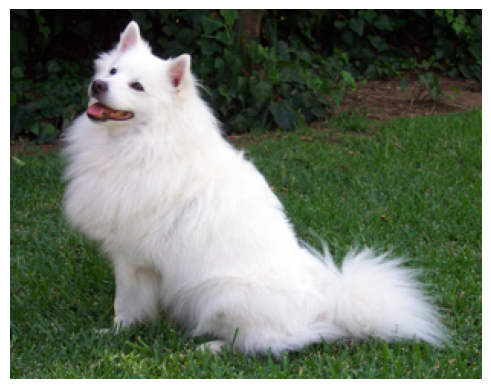

In [5]:
# Download an example image
url = "https://github.com/pytorch/hub/raw/master/images/dog.jpg"
input_image = Image.fromarray(skimage.io.imread(url))  # Load and convert to PIL format

# Resize and display the image for easy viewing
input_image = input_image.resize((input_image.width // 5, input_image.height // 5))
plt.imshow(input_image)
plt.axis('off')
plt.show()

## Transforming the Image into a Tensor

Pretrained models expect input images in a specific format:
- Images are typically mini-batches of 3-channel RGB images with shape `(3 x H x W)`, where `H` and `W` should be at least 224.
- The image values should be in the range `[0, 1]`, then normalised with `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`.

Here’s a sample transformation:

In [7]:
# Define preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply preprocessing and create a mini-batch
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)  # Create a batch dimension

## Running the Model

In evaluation mode, we use `with torch.no_grad()` to prevent the computation of gradients, making processing more efficient as we won’t need backpropagation.

In [13]:
# Move to GPU if available for faster computation
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

# Run the model in evaluation mode
with torch.no_grad():
    output = model(input_batch)

# Output size should match the 1000 ImageNet classes
print(f'{"Output size:":<20} \t {output.shape}')
# Convert output scores to probabilities using softmax
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(f'{"Probabilities size:":<20} \t {probabilities.shape}')

Output size:         	 torch.Size([1, 1000])
Probabilities size:  	 torch.Size([1000])


## Assessing the Output

To interpret the model’s output, we need the labels corresponding to the 1000 ImageNet classes. We’ll retrieve these labels online.

In [14]:
# Download ImageNet labels
import requests

url = 'https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt'
response = requests.get(url)
imagenet_classes = response.text.splitlines()  # Convert the text to a list

# Verify the labels list
print(len(imagenet_classes))  # Should be 1000
print(imagenet_classes[:10])  # Show the first 10 classes

1000
['tench', 'goldfish', 'great white shark', 'tiger shark', 'hammerhead', 'electric ray', 'stingray', 'cock', 'hen', 'ostrich']


Now, let’s display the top 5 predicted categories for our image.

In [15]:
# Get the top 5 categories
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(f'{imagenet_classes[top5_catid[i]]:<17} {top5_prob[i].item():.3f}')

Samoyed           0.859
Arctic fox        0.055
white wolf        0.049
Pomeranian        0.008
Great Pyrenees    0.007


***

## Assignment 

For this assignment, please address the following tasks. Submit your responses in a single **notebook (.ipynb)** that includes code, comments, written text, and plots. Ensure that the notebook is self-contained and can be run on other machines.

### 1. Visualise Kernels of the First Layer

Access the weights of the first layer using `conv1.weight`, which has a shape of `torch.Size([64, 3, 7, 7])`. Your visualisation should display 64 colour kernels of size $7 \times 7$.

### 2. Load Multiple Images

Modify `input_batch` to load 4 different images, run the model on all 4 simultaneously, and display the predicted classes for each image.

### 3. Explore a Different Architecture

Visualise the first-layer kernels of a different network such as AlexNet (`models.alexnet`), VGG (`models.vgg16`), or ViT-B16 (`models.vit_b_16`). Compare these kernels with what you know about the receptive fields in the mammalian visual cortex. Discuss any similarities and differences.

***

## Bonus Questions (Optional)

These questions will provide extra points.

### 4. Add Noise to the First Layer

Add a type of noise (e.g., Gaussian or Poisson) to the weights of the first layer (`conv1.weight` or `conv1.bias`). Evaluate how sensitive the network is to this noise.

### 5. Add Noise to the Input Image

Add noise to the input images and observe how the network's predictions are affected.

### 6. Convolve with a Single Kernel

Convolve the input image with the first kernel in the first layer and visualise the resulting output.

### 7. Apply an Activation Function

Apply an activation function, like ReLU, to the output of the convolution in the previous step.

### 8. Pooling Operation

Apply a pooling function (e.g., max pooling with a $2 \times 2$ window) to the convolution output from the previous step.

### 9. Linear Layer

Apply a linear layer with an output node size of 1000 to the convolution output from the previous steps.